In [1]:
import sys
import os
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

import xgboost as xgb
from tqdm import tqdm

sys.path.append('/root/jpx/')
sys.path.append('/root/jpx/predict/src')
from pipeline import ml_pipeline
from predictor import ScoringService 



DATASET_DIR='/root/jpx/data'
MODEL_PATH="/root/jpx/predict/model"

pd.options.display.max_columns = 120
pd.options.display.max_rows = 120
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
/o

In [2]:
inputs = ScoringService.get_inputs(DATASET_DIR)
inputs

{'stock_list': '/root/milize_project/jpx/data/stock_list.csv.gz',
 'stock_price': '/root/milize_project/jpx/data/stock_price.csv.gz',
 'stock_fin': '/root/milize_project/jpx/data/stock_fin.csv.gz',
 'stock_labels': '/root/milize_project/jpx/data/stock_labels.csv.gz'}

In [3]:
dfs = ScoringService.get_dataset(inputs)
codes = ScoringService.get_codes(dfs)

In [4]:
dfs['stock_labels']['Local Code']

datetime
2016-01-04    1301
2016-01-05    1301
2016-01-06    1301
2016-01-07    1301
2016-01-08    1301
              ... 
2021-03-22    9997
2021-03-23    9997
2021-03-24    9997
2021-03-25    9997
2021-03-26    9997
Name: Local Code, Length: 4394888, dtype: int64

In [5]:
stock_list = dfs['stock_list'].rename(columns={'Local Code':'code'})

In [6]:
# 10分くらいかかります
feats = ScoringService.get_features_for_predict(codes, is_dask=True)

INFO : 2021-03-27 15:32:20,235 : exec FE by dask
INFO : 2021-03-27 15:39:02,750 : price_indicator FE end
INFO : 2021-03-27 15:39:02,750 : start lag FE
INFO : 2021-03-27 15:40:49,489 : end lag FE


In [7]:
feats

EndOfDayQuote ExchangeOfficialClose  \
Local Code datetime                                          
1436       2016-03-11                               1510.0   
           2016-03-14                               1405.0   
           2016-03-15                               1489.0   
           2016-03-16                               1477.0   
           2016-03-17                               1415.0   
...                                                    ...   
9974       2021-03-22                               6260.0   
           2021-03-23                               6120.0   
           2021-03-24                               6130.0   
           2021-03-25                               6280.0   
           2021-03-26                               6260.0   

                       EndOfDayQuote Volume        rsi         atr  \
Local Code datetime                                                  
1436       2016-03-11             2009800.0        NaN         NaN   
           2016-03-14              413800.0        NaN         NaN   
           2016-03-15              164700.0        NaN         NaN   
           2016-03-16               76700.0        NaN         NaN   
           2016-03-17               65200.0        NaN         NaN   
...                                     ...        ...         ...   
9974       2021-03-22               55300.0  70.800666  499.099810   
           2021-03-23               28700.0  60.962503  512.021252   
           2021-03-24               56000.0  61.375358  521.876877   
           2021-03-25               40600.0  67.011194  532.457100   
           2021-03-26               28600.0  65.636014  531.567307   

                             macd       signal    dollar_vol  return_1d  \
Local Code datetime                                                       
1436       2016-03-11         NaN          NaN  3.034798e+09        NaN   
           2016-03-14         NaN          NaN  5.813890e+08  -0.069536   
           2016-03-15         NaN          NaN  2.452383e+08   0.059786   
           2016-03-16         NaN          NaN  1.132859e+08  -0.008059   
           2016-03-17         NaN          NaN  9.225800e+07  -0.041977   
...                           ...          ...           ...        ...   
9974       2021-03-22  150.254586  6003.333333  3.461780e+08   0.009677   
           2021-03-23  154.236464  6043.333333  1.756440e+08  -0.022364   
           2021-03-24  158.487106  6078.888889  3.432800e+08   0.001634   
           2021-03-25  170.042110  6124.444444  2.549680e+08   0.024470   
           2021-03-26  174.462460  6157.777778  1.790360e+08  -0.003185   

                       return_5d  return_10d  return_21d  return_42d  \
Local Code datetime                                                    
1436       2016-03-11        NaN         NaN         NaN         NaN   
           2016-03-14        NaN         NaN         NaN         NaN   
           2016-03-15        NaN         NaN         NaN         NaN   
           2016-03-16        NaN         NaN         NaN         NaN   
           2016-03-17        NaN         NaN         NaN         NaN   
...                          ...         ...         ...         ...   
9974       2021-03-22   0.009870    0.011023    0.004055    0.001737   
           2021-03-23   0.003300    0.005732    0.002808    0.001362   
           2021-03-24   0.002631    0.006245    0.003386    0.001401   
           2021-03-25   0.005833    0.007809    0.005131    0.001813   
           2021-03-26   0.001928    0.006453    0.005749    0.001901   

                       return_63d  return_1d_lag1  return_5d_lag1  \
Local Code datetime                                                 
1436       2016-03-11         NaN             NaN             NaN   
           2016-03-14         NaN             NaN             NaN   
           2016-03-15         NaN       -0.069536             NaN   
           2016-03-16         NaN        0.0597

In [8]:
# ファンダメンタル情報（決算数値データや配当データ等）の追加
df_fundamental_feature = ScoringService.get_fundamental_feature(feats, codes)

In [9]:
df_fundamental_feature

,code,base_date,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement AccountingStandard,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement ModifyDate,Forecast_FinancialStatement CompanyType,Forecast_FinancialStatement ChangeOfFiscalYearEnd,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalPeriodEnd,Result_Dividend ReportType,Result_Dividend FiscalYear,Result_Dividend ModifyDate,Result_Dividend RecordDate,Result_Dividend DividendPayableDate,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalPeriodEnd,Forecast_Dividend ReportType,Forecast_Dividend FiscalYear,Forecast_Dividend ModifyDate,Forecast_Dividend RecordDate,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,rsi,atr,macd,signal,dollar_vol,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,return_1d_lag1,return_5d_lag1,return_10d_lag1,return_21d_lag1,return_1d_lag2,return_5d_lag2,return_10d_lag2,return_21d_lag2,return_1d_lag3,return_5d_lag3,return_10d_lag3,return_21d_lag3,return_1d_lag4,return_5d_lag4,return_10d_lag4,return_21d_lag4,return_1d_lag5,return_5d_lag5,return_10d_lag5,return_21d_lag5,return_1month,return_2month,return_3month,volatility_2days,volatility_5days,volatility_10days,volatility_20days,volatility_40days,volatility_60days,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,2753,2016/01/04,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,2391.0,2466.0,1645.0,21251.0,16962.0,NaN,NaN,NaN,ConsolidatedJP,2016/03,Annual,2016.0,2016/01/04,GB,False,30500.0,3110.0,3200.0,2130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,45.0,90.0,4710.0,12200.0,NaN,NaN,NaN,NaN,5.746200e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-12,0.01062,-0.04034,2016-01-19,0.01062,-0.05945,2016-02-02,0.03609,-0.10616,2016/01/04,4750.0,4800.0,4620.0,4710.0,1.0,4680.0,2015/12/30,4680.0,2015/12/30,30.0,0.641,4706.598
2016-01-04,3353,2016/01/04,ConsolidatedJP,2015/11,Q3,2016.0,2016/01/04,GB,False,21550.0,1038.0,1053.0,697.0,24949.0,7145.0,NaN,NaN,NaN,ConsolidatedJP,2016/02,Annual,2016.0,2016/01/04,GB,False,27800.0,1320.0,1310.0,840.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/02,Annual,2016.0,2016/01/04,2016/02/29,32.5,65.0,4900.0,0.0,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [10]:
# 銘柄の名前や業種区分などの基本情報の
df_learning = ScoringService.calc_fundamental_feature(df_fundamental_feature)

In [11]:
df_learning

,code,base_date,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement AccountingStandard,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement ModifyDate,Forecast_FinancialStatement CompanyType,Forecast_FinancialStatement ChangeOfFiscalYearEnd,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalPeriodEnd,Result_Dividend ReportType,Result_Dividend FiscalYear,Result_Dividend ModifyDate,Result_Dividend RecordDate,Result_Dividend DividendPayableDate,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalPeriodEnd,Forecast_Dividend ReportType,Forecast_Dividend FiscalYear,Forecast_Dividend ModifyDate,Forecast_Dividend RecordDate,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,rsi,atr,macd,signal,dollar_vol,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,return_1d_lag1,return_5d_lag1,return_10d_lag1,...,return_10d_lag3,return_21d_lag3,return_1d_lag4,return_5d_lag4,return_10d_lag4,return_21d_lag4,return_1d_lag5,return_5d_lag5,return_10d_lag5,return_21d_lag5,return_1month,return_2month,return_3month,volatility_2days,volatility_5days,volatility_10days,volatility_20days,volatility_40days,volatility_60days,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP,prediction_target,Effective Date,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare,market_cap,per,pbr,roe,profit_margin,equity_ratio
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,2753,2016/01/04,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,2391.0,2466.0,1645.0,21251.0,16962.0,NaN,NaN,NaN,ConsolidatedJP,2016/03,Annual,2016.0,2016/01/04,GB,False,30500.0,3110.0,3200.0,2130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,45.0,90.0,4710.0,12200.0,NaN,NaN,NaN,NaN,5.746200e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-12,0.01062,-0.04034,2016-01-19,0.01062,-0.05945,2016-02-02,0.03609,-0.10616,2016/01/04,4750.0,4800.0,4620.0,4710.0,1.0,4680.0,2015/12/30,4680.0,2015/12/30,30.0,0.641,4706.598,True,20210226,"AMIYAKI TEI CO.,LTD.",First Section (Domestic),6100.0,Retail Trade,14.0,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,3.225785e+10,19.609634,1.901771,0.096981,0.073589,

In [12]:
feature_columns = ScoringService.get_feature_columns(dfs, feats)

In [13]:
# 使用する特徴量
feature_columns

['Result_FinancialStatement FiscalYear',
 'Result_FinancialStatement NetSales',
 'Result_FinancialStatement OperatingIncome',
 'Result_FinancialStatement OrdinaryIncome',
 'Result_FinancialStatement NetIncome',
 'Result_FinancialStatement TotalAssets',
 'Result_FinancialStatement NetAssets',
 'Result_FinancialStatement CashFlowsFromOperatingActivities',
 'Result_FinancialStatement CashFlowsFromFinancingActivities',
 'Result_FinancialStatement CashFlowsFromInvestingActivities',
 'Forecast_FinancialStatement FiscalYear',
 'Forecast_FinancialStatement NetSales',
 'Forecast_FinancialStatement OperatingIncome',
 'Forecast_FinancialStatement OrdinaryIncome',
 'Forecast_FinancialStatement NetIncome',
 'Result_Dividend FiscalYear',
 'Result_Dividend QuarterlyDividendPerShare',
 'Result_Dividend AnnualDividendPerShare',
 'Forecast_Dividend FiscalYear',
 'Forecast_Dividend QuarterlyDividendPerShare',
 'Forecast_Dividend AnnualDividendPerShare',
 'IssuedShareEquityQuote IssuedShare',
 'market_cap

In [17]:
import config

fundamental_cols_category =  config.fundamental_cols_category

# カテゴリー
for i in fundamental_cols_category:
    print(i)
    print(df_learning[i].unique())
    print('-------------')


Result_FinancialStatement AccountingStandard
['ConsolidatedJP' 'NaN' 'NonConsolidated' 'ConsolidatedIFRS'
 'ConsolidatedUS']
-------------
Result_FinancialStatement ReportType
['Q3' 'NaN' 'Q2' 'Q1' 'Annual']
-------------
Result_FinancialStatement CompanyType
['GB' 'NaN' 'SE' 'BK' 'IN']
-------------
Result_FinancialStatement ChangeOfFiscalYearEnd
['False' 'NaN' 'True']
-------------
Forecast_FinancialStatement AccountingStandard
['ConsolidatedJP' 'NonConsolidated' 'ConsolidatedIFRS' 'NaN'
 'ConsolidatedUS']
-------------
Forecast_FinancialStatement ReportType
['Annual' 'Q2' 'NaN' 'Q3' 'Q1']
-------------
Forecast_FinancialStatement CompanyType
['GB' 'NaN' 'SE' 'BK' 'IN']
-------------
Forecast_FinancialStatement ChangeOfFiscalYearEnd
['False' 'NaN' 'True']
-------------
Result_Dividend ReportType
['NaN' 'Annual' 'Q3' 'Q1' 'Q2']
-------------
Forecast_Dividend ReportType
['Annual' 'Q2' 'NaN' 'Q3' 'Q1']
-------------
Section/Products
['First Section (Domestic)' 'JASDAQ(Standard / Domest

In [18]:
labels = [
    "label_high_5",
    "label_high_10",
    "label_high_20",
    "label_low_5",
    "label_low_10",
    "label_low_20",
]


# データ分割期間を定義
TRAIN_START = "2018-01-01"
TRAIN_END = "2020-09-30"
VAL_START = "2020-10-01"
VAL_END = "2020-12-31"
TEST_START = "2021-01-01"

# モデルを定義
models = {
    "rf": RandomForestRegressor(max_depth=5, random_state=0),
    "LinearRegression" : LinearRegression(),
    "xgb": xgb.XGBRegressor(max_depth=5, random_state=0)
}



train =  df_learning.loc[TRAIN_START: TRAIN_END]
val = df_learning.loc[VAL_START : VAL_END]
test = df_learning.loc[TEST_START :]



# モデルを選択
model = "xgb"

# 目的変数を指定
label = "label_high_20"


# 特徴量グループを指定
col = "fundamental+technical"

pred_model = ml_pipeline(model=models[model], features=feature_columns, category_variable=fundamental_cols_category)

pred_model.fit(train[feature_columns], train[label])

Pipeline(memory=None,
     steps=[('categorical_encoder', TransformerWrapper(transformer=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>),
          variables=['Result_FinancialStatement AccountingStandard', 'Result_FinancialStatement ReportType', 'Result_FinancialStatement CompanyType', 'Result_FinancialState...w Index Series)', 'Size (New Index Series)', 'IssuedShareEquityQuote AccountingStandard', 'code']))])

In [19]:
train[feature_columns]

,Result_FinancialStatement FiscalYear,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalYear,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalYear,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare,IssuedShareEquityQuote IssuedShare,market_cap,per,pbr,roe,profit_margin,equity_ratio,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,rsi,atr,macd,signal,dollar_vol,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,return_1d_lag1,return_5d_lag1,return_10d_lag1,return_21d_lag1,return_1d_lag2,return_5d_lag2,return_10d_lag2,return_21d_lag2,return_1d_lag3,return_5d_lag3,return_10d_lag3,return_21d_lag3,return_1d_lag4,return_5d_lag4,return_10d_lag4,return_21d_lag4,return_1d_lag5,return_5d_lag5,return_10d_lag5,return_21d_lag5,return_1month,return_2month,return_3month,volatility_2days,volatility_5days,volatility_10days,volatility_20days,volatility_40days,volatility_60days,Result_FinancialStatement AccountingStandard,Result_FinancialStatement ReportType,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Forecast_FinancialStatement AccountingStandard,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement CompanyType,Forecast_FinancialStatement ChangeOfFiscalYearEnd,Result_Dividend ReportType,Forecast_Dividend ReportType,Section/Products,33 Sector(Code),17 Sector(Code),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,code
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-04,2018.0,23555.0,2251.0,2310.0,1524.0,24111.0,19804.0,NaN,NaN,NaN,2018.0,32000.0,3210.0,3250.0,2170.0,2018.0,50.0,NaN,2018.0,50.0,100.0,6848800.0,3.629864e+10,23.818005,1.832894,0.076954,0.064700,0.821368,5390.0,5390.0,5250.0,5300.0,1.0,5310.0,5310.0,-10.0,-0.188,5304.970,5300.0,16700.0,61.496212,270.047573,61.838540,5234.444444,88510000.0,-0.001883,0.004979,0.000948,0.002209,-0.000090,0.001774,0.015296,-0.003066,0.004290,-0.002383,0.003839,0.007002,-0.001185,0.005512,-0.003824,0.001585,-0.007356,0.000000,0.011605,-0.000793,0.008405,0.005662,-0.001931,-0.001577,0.006688,0.000856,0.053678,-0.032847,0.124072,63.639610,43.358967,51.693541,47.933616,55.606216,80.603786,ConsolidatedJP,Q3,GB,False,ConsolidatedJP,Annual,GB,False,Q2,Annual,First Section (Domestic),6100.0,14.0,7,TOPIX Small 2,ConsolidatedJP,2753
2018-01-04,2017.0,2821.0,64.0,24.0,-123.0,5325.0,658.0,NaN,NaN,NaN,2017.0,4308.0,367.0,312.0,125.0,2017.0,0.0,NaN,2017.0,5.0,5.0,11253700.0,1.450602e+10,-117.935116,22.045622,-0.186930,-0.043602,0.123568,1272.0,1289.0,1272.0,1289.0,1.0,1273.0,1273.0,16.0,1.257,1280.939,1289.0,21300.0,38.651963,188.909849,-27.403349,1264.444444,27455700.0,0.012569,0.009579,-0.001995,-0.002724,-0.005645,-0.001932,-0.002351,-0.013436,-0.004089,-0.008558,-0.004680,-0.002266,-0.022438,0.005537,0.039740,-0.005909,0.005763,0.010468,0.003255,-0.043592,0.004031,0.008035,-0.027690,-0.000816,-0.002030,0.003867,-0.059124,-0.205792,-0.189818,13.435029,22.349497,23.590017,21.318327,49.070619

,predict,actual
predict,1.000000,0.114329
actual,0.114329,1.000000


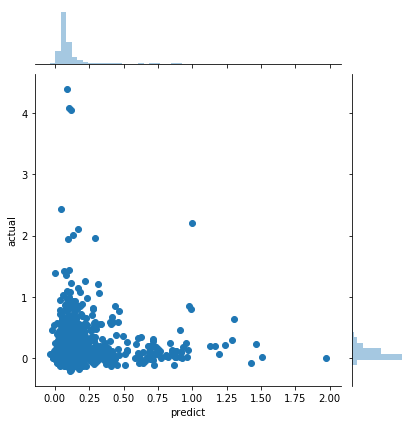

0.16891727991779668

In [20]:
import importlib
import learner.preprocessors
importlib.reload( learner.preprocessors)
import  learner.preprocessors
from learner.preprocessors import ExperimentManagement


exp = ExperimentManagement(df_learning=df_learning, feature_columns=feature_columns)
exp.set_model_label(model=models[model], label=label)
result = exp.get_result(pred_model, val, label='label_high_20', is_plot=True)
spearmanr(result[label]["actual"], result[label]["predict"])[0]

In [21]:
df_learning

,code,base_date,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement AccountingStandard,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement ModifyDate,Forecast_FinancialStatement CompanyType,Forecast_FinancialStatement ChangeOfFiscalYearEnd,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalPeriodEnd,Result_Dividend ReportType,Result_Dividend FiscalYear,Result_Dividend ModifyDate,Result_Dividend RecordDate,Result_Dividend DividendPayableDate,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalPeriodEnd,Forecast_Dividend ReportType,Forecast_Dividend FiscalYear,Forecast_Dividend ModifyDate,Forecast_Dividend RecordDate,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,rsi,atr,macd,signal,dollar_vol,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,return_1d_lag1,return_5d_lag1,return_10d_lag1,...,return_10d_lag3,return_21d_lag3,return_1d_lag4,return_5d_lag4,return_10d_lag4,return_21d_lag4,return_1d_lag5,return_5d_lag5,return_10d_lag5,return_21d_lag5,return_1month,return_2month,return_3month,volatility_2days,volatility_5days,volatility_10days,volatility_20days,volatility_40days,volatility_60days,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP,prediction_target,Effective Date,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare,market_cap,per,pbr,roe,profit_margin,equity_ratio
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,2753,2016/01/04,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,2391.0,2466.0,1645.0,21251.0,16962.0,NaN,NaN,NaN,ConsolidatedJP,2016/03,Annual,2016.0,2016/01/04,GB,False,30500.0,3110.0,3200.0,2130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,45.0,90.0,4710.0,12200.0,NaN,NaN,NaN,NaN,5.746200e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-12,0.01062,-0.04034,2016-01-19,0.01062,-0.05945,2016-02-02,0.03609,-0.10616,2016/01/04,4750.0,4800.0,4620.0,4710.0,1.0,4680.0,2015/12/30,4680.0,2015/12/30,30.0,0.641,4706.598,True,20210226,"AMIYAKI TEI CO.,LTD.",First Section (Domestic),6100.0,Retail Trade,14.0,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,3.225785e+10,19.609634,1.901771,0.096981,0.073589,

# 検証1 大きくずれているものを検証

In [22]:
df_bench = pd.DataFrame(
    pred_model.predict(train[feature_columns]), columns=["predict"]
)
df_bench["actual"] = train[label].values
df_bench["datetime"] = train[feature_columns].index
df_bench["code"] = train["code"].values
df_bench = df_bench.set_index('datetime')

df_bench['diff_abs'] = abs(df_bench["actual"] - df_bench["predict"] )
df_bench['diff'] = df_bench["actual"] - df_bench["predict"]
df_bench = df_bench.sort_values(by='diff_abs', ascending=False)

df_predict = result[label]
df_predict['diff_abs'] = abs(df_predict["actual"] - df_predict["predict"] )

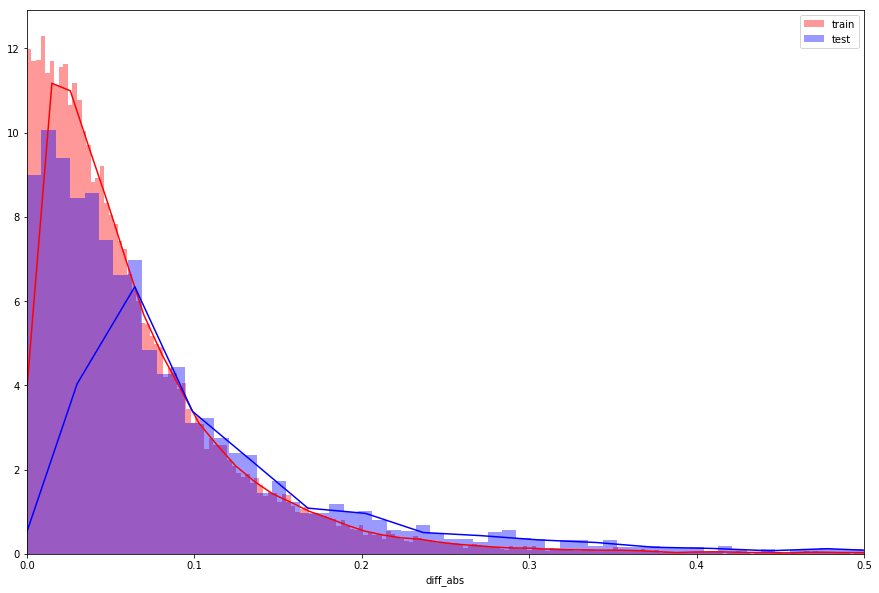

In [23]:
plt.figure(figsize=(15, 10))
sns.distplot(
   df_bench['diff_abs'] , bins=500, color='r', label='train',
    kde=True
)
sns.distplot(
   df_predict['diff_abs'] , bins=500, color='b', label='test',
    kde=True
)
plt.xlim([0, 0.5])
plt.legend()
plt.show()

In [24]:
df_bench[df_bench.diff_abs>0.5] # こいつ抜くとどうなる？


# 株式会社　安永 の2016-11-10

,predict,actual,code,diff_abs,diff
datetime,,,,,
2019-08-14,3.683931,5.04186,3747,1.357929,1.357929
2018-05-11,0.569552,1.73529,8705,1.165738,1.165738
2019-11-11,0.092353,1.24852,9625,1.156167,1.156167
2020-02-14,0.180795,1.27634,3691,1.095545,1.095545
2018-02-08,0.437315,1.48166,6276,1.044345,1.044345
...,...,...,...,...,...
2019-11-14,0.571769,1.07344,3933,0.501671,0.501671
2019-04-18,0.247187,0.74874,4316,0.501553,0.501553
2018-04-13,0.358830,0.85990,6634,0.501070,0.501070


In [25]:
df_result_train = train.copy()
df_result_train = pd.merge(df_result_train.reset_index(), df_bench.reset_index(), on=['datetime', 'code'], how='left')

In [26]:
# 全体の平均は0.08588004057153045 +/- 0.16217730452814788


df_result_17sec = df_result_train.groupby('17 Sector(Code)')['diff_abs'].describe().sort_values(by='mean')
pd.merge(df_result_17sec.reset_index(), dfs['stock_list'][['17 Sector(Code)', '17 Sector(name)']].astype(str).drop_duplicates(),
         on=['17 Sector(Code)'])


,17 Sector(Code),count,mean,std,min,25%,50%,75%,max,17 Sector(name)
0,15.0,990.0,0.036201,0.040862,7.908113e-05,0.013074,0.026801,0.047565,0.706323,BANKS
1,12.0,1413.0,0.044208,0.049821,9.181133e-05,0.017016,0.032687,0.053785,0.758826,TRANSPORTATION & LOGISTICS
2,1.0,1621.0,0.046307,0.057075,3.523965e-05,0.014889,0.031391,0.057744,0.994450,FOODS
3,11.0,283.0,0.048020,0.050171,3.994501e-04,0.018214,0.033975,0.057469,0.329650,ELECTRIC POWER & GAS
4,6.0,1333.0,0.052719,0.062498,1.430739e-04,0.019721,0.040380,0.067877,0.876214,AUTOMOBILES & TRANSPORTATION EQUIPMENT
5,2.0,219.0,0.053378,0.052262,5.536779e-04,0.023079,0.042796,0.068643,0.509425,ENERGY RESOURCES
6,13.0,3927.0,0.055297,0.062717,8.691502e-07,0.018240,0.038087,0.070491,0.856363,COMMERCIAL & WHOLESALE TRADE
7,4.0,3525.0,0.058135,0.064669,9.480118e-06,0.019938,0.041400,0.076178,0.942899,RAW MATERIALS & CHEMICALS
8,3.0,3749.0,0.059260,0.066996,1.291060e-06,0.019433,0.042359,0.075306,0.989544,CONSTRUCTION & MATERIALS
9,16.0,1256.0,0.060228,0.074838,4.820985e-05,0.020198,0.041689,0.074842,1.165738,FINANCIALS （EX BANKS）


In [27]:
df_result_33sec = df_result_train.groupby('33 Sector(Code)')['diff_abs'].describe().sort_values(by='mean')
pd.merge(df_result_33sec.reset_index(), dfs['stock_list'][['33 Sector(Code)', '33 Sector(name)']].astype(str).drop_duplicates(),
         on=['33 Sector(Code)'])



,33 Sector(Code),count,mean,std,min,25%,50%,75%,max,33 Sector(name)
0,7050.0,990.0,0.036201,0.040862,7.908113e-05,0.013074,0.026801,0.047565,0.706323,Banks
1,5050.0,735.0,0.040810,0.043421,1.478628e-04,0.015657,0.029214,0.050347,0.526260,Land Transportation
2,3050.0,1489.0,0.045529,0.056493,3.523965e-05,0.014510,0.030798,0.056657,0.994450,Foods
3,5200.0,450.0,0.046067,0.052305,9.181133e-05,0.019731,0.036080,0.056127,0.758826,Warehousing and Harbor Transportation Service
4,5100.0,166.0,0.046552,0.039648,4.160457e-04,0.018155,0.038024,0.064077,0.259964,Marine Transportation
5,1050.0,74.0,0.047830,0.035132,1.335926e-03,0.022455,0.039275,0.061208,0.149535,Mining
6,4050.0,283.0,0.048020,0.050171,3.994501e-04,0.018214,0.033975,0.057469,0.329650,Electric Power and Gas
7,3350.0,230.0,0.052532,0.062769,1.533595e-04,0.017675,0.042405,0.066347,0.526870,Rubber Products
8,3700.0,1103.0,0.052758,0.062470,1.430739e-04,0.020062,0.039992,0.068267,0.876214,Transportation Equipment
9,3550.0,1107.0,0.053297,0.059327,1.291060e-06,0.017783,0.040102,0.067337,0.712026,Metal Products


In [28]:
df_result_33sec = df_result_train.groupby('33 Sector(Code)')['diff_abs'].describe().sort_values(by='mean')
pd.merge(df_result_33sec.reset_index(), dfs['stock_list'][['33 Sector(Code)', '33 Sector(name)']].astype(str).drop_duplicates(),
         on=['33 Sector(Code)'])

,33 Sector(Code),count,mean,std,min,25%,50%,75%,max,33 Sector(name)
0,7050.0,990.0,0.036201,0.040862,7.908113e-05,0.013074,0.026801,0.047565,0.706323,Banks
1,5050.0,735.0,0.040810,0.043421,1.478628e-04,0.015657,0.029214,0.050347,0.526260,Land Transportation
2,3050.0,1489.0,0.045529,0.056493,3.523965e-05,0.014510,0.030798,0.056657,0.994450,Foods
3,5200.0,450.0,0.046067,0.052305,9.181133e-05,0.019731,0.036080,0.056127,0.758826,Warehousing and Harbor Transportation Service
4,5100.0,166.0,0.046552,0.039648,4.160457e-04,0.018155,0.038024,0.064077,0.259964,Marine Transportation
5,1050.0,74.0,0.047830,0.035132,1.335926e-03,0.022455,0.039275,0.061208,0.149535,Mining
6,4050.0,283.0,0.048020,0.050171,3.994501e-04,0.018214,0.033975,0.057469,0.329650,Electric Power and Gas
7,3350.0,230.0,0.052532,0.062769,1.533595e-04,0.017675,0.042405,0.066347,0.526870,Rubber Products
8,3700.0,1103.0,0.052758,0.062470,1.430739e-04,0.020062,0.039992,0.068267,0.876214,Transportation Equipment
9,3550.0,1107.0,0.053297,0.059327,1.291060e-06,0.017783,0.040102,0.067337,0.712026,Metal Products


In [29]:
for i in df_result_train.select_dtypes(include=["object"]):
    print(i)
    display( df_result_train.groupby(i)['diff_abs'].describe().sort_values(by='mean'))

base_date


,count,mean,std,min,25%,50%,75%,max
base_date,,,,,,,,
2018/01/04,2.0,0.016581,0.008544,0.010539,0.013560,0.016581,0.019602,0.022623
2018/08/20,1.0,0.016952,NaN,0.016952,0.016952,0.016952,0.016952,0.016952
2018/11/27,8.0,0.017715,0.023417,0.000037,0.001265,0.001828,0.038421,0.056799
2019/11/26,4.0,0.020734,0.005710,0.014913,0.016553,0.020415,0.024597,0.027194
2019/11/19,4.0,0.023811,0.017435,0.004511,0.011849,0.024202,0.036163,0.042330
...,...,...,...,...,...,...,...,...
2019/10/16,12.0,0.186554,0.178274,0.003381,0.054959,0.127168,0.277952,0.582515
2020/08/17,8.0,0.216494,0.313936,0.031691,0.086245,0.100989,0.157779,0.983689
2019/11/28,5.0,0.219482,0.373413,0.005853,0.008254,0.069545,0.132834,0.880923


Result_FinancialStatement AccountingStandard


,count,mean,std,min,25%,50%,75%,max
Result_FinancialStatement AccountingStandard,,,,,,,,
NaN,12.0,0.038487,0.039699,6.097715e-03,0.011188,0.017188,0.054587,0.115586
ConsolidatedUS,154.0,0.040903,0.031285,1.098079e-03,0.019689,0.034127,0.054042,0.175578
ConsolidatedIFRS,2172.0,0.062914,0.061771,8.904631e-06,0.021279,0.047099,0.082690,0.620163
ConsolidatedJP,36376.0,0.065741,0.074571,8.691502e-07,0.021234,0.045434,0.085133,1.357929
NonConsolidated,5953.0,0.074640,0.084508,8.668403e-06,0.022806,0.050998,0.098150,1.156167


Result_FinancialStatement FiscalPeriodEnd


,count,mean,std,min,25%,50%,75%,max
Result_FinancialStatement FiscalPeriodEnd,,,,,,,,
2019/12,3848.0,0.059016,0.060575,2.317486e-05,0.021446,0.043666,0.079537,1.095545
2019/06,3512.0,0.062090,0.075084,8.668403e-06,0.020824,0.043100,0.077560,1.357929
2019/09,3218.0,0.062876,0.078762,8.691502e-07,0.019385,0.040981,0.076598,1.156167
2017/06,7.0,0.063192,0.038676,1.151054e-02,0.037127,0.053136,0.096242,0.110960
2019/03,3192.0,0.063312,0.072353,1.133126e-05,0.019806,0.043856,0.082085,0.967566
2018/06,3486.0,0.064004,0.071547,1.291060e-06,0.019610,0.043161,0.084394,0.932565
2018/09,3211.0,0.064570,0.069369,9.257020e-06,0.021000,0.045462,0.085044,0.942899
2018/12,3720.0,0.065026,0.073975,2.182317e-05,0.019927,0.043769,0.083879,0.974487
2018/03,3151.0,0.065045,0.072067,3.523965e-05,0.021213,0.045129,0.084727,1.021729


Result_FinancialStatement ReportType


,count,mean,std,min,25%,50%,75%,max
Result_FinancialStatement ReportType,,,,,,,,
NaN,12.0,0.038487,0.039699,6.097715e-03,0.011188,0.017188,0.054587,0.115586
Q3,13256.0,0.065746,0.074370,8.904631e-06,0.021511,0.045577,0.084610,1.357929
Q1,12248.0,0.066500,0.076672,1.291060e-06,0.021043,0.045440,0.085729,1.095545
Annual,10699.0,0.067025,0.072616,1.133126e-05,0.021423,0.047103,0.088275,1.021729
Q2,8452.0,0.068096,0.078447,8.691502e-07,0.021736,0.046677,0.087605,1.156167


Result_FinancialStatement ModifyDate


,count,mean,std,min,25%,50%,75%,max
Result_FinancialStatement ModifyDate,,,,,,,,
2019/06/20,1.0,0.002836,NaN,0.002836,0.002836,0.002836,0.002836,0.002836
2018/03/26,1.0,0.003477,NaN,0.003477,0.003477,0.003477,0.003477,0.003477
2020/02/17,3.0,0.003490,0.002878,0.000434,0.002160,0.003886,0.005017,0.006149
2017/12/29,1.0,0.004666,NaN,0.004666,0.004666,0.004666,0.004666,0.004666
2017/10/05,1.0,0.004944,NaN,0.004944,0.004944,0.004944,0.004944,0.004944
...,...,...,...,...,...,...,...,...
2018/09/21,5.0,0.226757,0.407238,0.001188,0.045403,0.056286,0.077363,0.953545
2018/05/16,2.0,0.273135,0.358836,0.019399,0.146267,0.273135,0.400002,0.526870
2017/12/12,5.0,0.284710,0.403932,0.048159,0.051991,0.094173,0.234777,0.994450


Result_FinancialStatement CompanyType


,count,mean,std,min,25%,50%,75%,max
Result_FinancialStatement CompanyType,,,,,,,,
BK,987.0,0.036247,0.040914,7.908113e-05,0.013052,0.026807,0.047604,0.706323
NaN,12.0,0.038487,0.039699,6.097715e-03,0.011188,0.017188,0.054587,0.115586
IN,145.0,0.056671,0.058793,1.172087e-04,0.016413,0.035554,0.078474,0.333050
SE,1112.0,0.061071,0.077136,4.820985e-05,0.021034,0.042591,0.074842,1.165738
GB,42411.0,0.067595,0.075851,8.691502e-07,0.021759,0.046909,0.087823,1.357929


Result_FinancialStatement ChangeOfFiscalYearEnd


,count,mean,std,min,25%,50%,75%,max
Result_FinancialStatement ChangeOfFiscalYearEnd,,,,,,,,
NaN,12.0,0.038487,0.039699,6.097715e-03,0.011188,0.017188,0.054587,0.115586
False,44601.0,0.066681,0.075353,8.691502e-07,0.021380,0.046074,0.086460,1.357929
True,54.0,0.085852,0.096364,4.409848e-03,0.027400,0.054101,0.113075,0.555906


Forecast_FinancialStatement AccountingStandard


,count,mean,std,min,25%,50%,75%,max
Forecast_FinancialStatement AccountingStandard,,,,,,,,
ConsolidatedUS,122.0,0.040007,0.029580,2.022693e-03,0.019838,0.033079,0.052252,0.134776
ConsolidatedIFRS,1997.0,0.061798,0.060035,8.904631e-06,0.020961,0.045955,0.081730,0.526067
ConsolidatedJP,33668.0,0.065763,0.074579,8.691502e-07,0.021157,0.045273,0.085134,1.357929
NaN,3425.0,0.067383,0.076042,1.375418e-05,0.022373,0.048846,0.086687,1.095545
NonConsolidated,5455.0,0.074418,0.084493,8.668403e-06,0.022434,0.050812,0.098146,1.156167


Forecast_FinancialStatement FiscalPeriodEnd


,count,mean,std,min,25%,50%,75%,max
Forecast_FinancialStatement FiscalPeriodEnd,,,,,,,,
2017/11,13.0,0.057092,0.046322,3.107343e-04,0.027899,0.044575,0.075156,0.139619
2020/03,6985.0,0.058613,0.067508,8.691502e-07,0.019830,0.041112,0.074747,1.156167
2019/09,3823.0,0.058766,0.069654,1.133126e-05,0.019510,0.040967,0.074248,1.357929
2018/09,3887.0,0.060925,0.067314,1.291060e-06,0.019285,0.041814,0.080511,0.932565
2019/03,6811.0,0.061950,0.072356,9.257020e-06,0.019458,0.041488,0.080269,1.021729
2018/03,3021.0,0.063529,0.074096,8.904631e-06,0.021598,0.044146,0.079886,1.165738
2020/09,2181.0,0.065776,0.071277,3.030953e-05,0.021601,0.048096,0.087315,0.989544
2020/02,702.0,0.066499,0.076170,6.361295e-06,0.022083,0.046236,0.085624,1.018516
2019/05,277.0,0.068266,0.063672,3.035850e-04,0.022928,0.047606,0.093793,0.370382


Forecast_FinancialStatement ReportType


,count,mean,std,min,25%,50%,75%,max
Forecast_FinancialStatement ReportType,,,,,,,,
Q1,133.0,0.061254,0.050469,1.138102e-03,0.024028,0.048400,0.092129,0.210542
Q3,102.0,0.062894,0.052020,1.629642e-03,0.024173,0.050969,0.087038,0.259747
Q2,13425.0,0.063477,0.069632,1.291060e-06,0.020495,0.044318,0.083285,0.994450
NaN,3425.0,0.067383,0.076042,1.375418e-05,0.022373,0.048846,0.086687,1.095545
Annual,27582.0,0.068219,0.078063,8.691502e-07,0.021704,0.046784,0.087880,1.357929


Forecast_FinancialStatement ModifyDate


,count,mean,std,min,25%,50%,75%,max
Forecast_FinancialStatement ModifyDate,,,,,,,,
2018/01/04,2.0,0.016581,0.008544,0.010539,0.013560,0.016581,0.019602,0.022623
2018/08/20,1.0,0.016952,NaN,0.016952,0.016952,0.016952,0.016952,0.016952
2018/11/27,8.0,0.017715,0.023417,0.000037,0.001265,0.001828,0.038421,0.056799
2019/11/26,4.0,0.020734,0.005710,0.014913,0.016553,0.020415,0.024597,0.027194
2019/11/19,4.0,0.023811,0.017435,0.004511,0.011849,0.024202,0.036163,0.042330
...,...,...,...,...,...,...,...,...
2019/12/24,9.0,0.219835,0.311445,0.008672,0.089644,0.101414,0.139998,1.018516
2017/11/06,2.0,0.225683,0.156992,0.114673,0.170178,0.225683,0.281188,0.336693
2018/08/22,2.0,0.233457,0.053446,0.195665,0.214561,0.233457,0.252352,0.271248


Forecast_FinancialStatement CompanyType


,count,mean,std,min,25%,50%,75%,max
Forecast_FinancialStatement CompanyType,,,,,,,,
BK,965.0,0.036265,0.041196,7.908113e-05,0.013056,0.026807,0.047548,0.706323
IN,139.0,0.055866,0.058200,1.172087e-04,0.016286,0.034292,0.078260,0.333050
SE,641.0,0.066311,0.085978,2.407677e-04,0.020421,0.043742,0.082365,1.165738
NaN,3425.0,0.067383,0.076042,1.375418e-05,0.022373,0.048846,0.086687,1.095545
GB,39497.0,0.067425,0.075681,8.691502e-07,0.021674,0.046665,0.087575,1.357929


Forecast_FinancialStatement ChangeOfFiscalYearEnd


,count,mean,std,min,25%,50%,75%,max
Forecast_FinancialStatement ChangeOfFiscalYearEnd,,,,,,,,
False,41104.0,0.066599,0.075322,8.691502e-07,0.021277,0.045868,0.086363,1.357929
NaN,3425.0,0.067383,0.076042,1.375418e-05,0.022373,0.048846,0.086687,1.095545
True,138.0,0.078828,0.074830,5.594083e-04,0.023522,0.053974,0.097070,0.425544


Result_Dividend FiscalPeriodEnd


,count,mean,std,min,25%,50%,75%,max
Result_Dividend FiscalPeriodEnd,,,,,,,,
2017/01,2.0,0.029199,0.011785,2.086547e-02,0.025032,0.029199,0.033365,0.037532
2016/12,9.0,0.056920,0.069802,1.065235e-03,0.031559,0.031930,0.053246,0.236840
2017/03,273.0,0.058245,0.054603,1.955834e-03,0.022937,0.045084,0.075895,0.368815
2019/09,5371.0,0.058371,0.066218,8.691502e-07,0.020382,0.040984,0.075604,1.156167
2019/03,5884.0,0.059249,0.070127,8.668403e-06,0.019523,0.041517,0.074635,1.357929
2018/03,5815.0,0.061330,0.070543,1.291060e-06,0.019277,0.040783,0.079370,1.021729
2018/09,5311.0,0.062507,0.070848,9.257020e-06,0.019913,0.042784,0.080972,0.974487
2020/03,5164.0,0.064087,0.070483,1.375418e-05,0.021246,0.046646,0.085348,1.042056
2017/09,2911.0,0.065039,0.077226,8.904631e-06,0.021775,0.044824,0.081635,1.165738


Result_Dividend ReportType


,count,mean,std,min,25%,50%,75%,max
Result_Dividend ReportType,,,,,,,,
Annual,24304.0,0.066493,0.075008,1.291060e-06,0.021153,0.045892,0.086549,1.095545
NaN,34.0,0.066531,0.058928,2.182317e-05,0.016704,0.038281,0.113131,0.184507
Q2,20130.0,0.066677,0.075584,8.691502e-07,0.021652,0.046162,0.085782,1.357929
Q3,103.0,0.085785,0.082324,2.956757e-04,0.031216,0.059518,0.120334,0.553214
Q1,96.0,0.101851,0.107135,8.509788e-04,0.038449,0.075510,0.114214,0.535694


Result_Dividend ModifyDate


,count,mean,std,min,25%,50%,75%,max
Result_Dividend ModifyDate,,,,,,,,
2018/03/26,1.0,0.003477,NaN,0.003477,0.003477,0.003477,0.003477,0.003477
2017/12/29,1.0,0.004666,NaN,0.004666,0.004666,0.004666,0.004666,0.004666
2020/02/17,5.0,0.004846,0.004872,0.000434,0.001199,0.003886,0.006149,0.012562
2017/10/05,1.0,0.004944,NaN,0.004944,0.004944,0.004944,0.004944,0.004944
2017/10/20,1.0,0.006126,NaN,0.006126,0.006126,0.006126,0.006126,0.006126
...,...,...,...,...,...,...,...,...
2019/10/16,3.0,0.215551,0.196205,0.017462,0.118419,0.219375,0.314596,0.409817
2020/08/17,8.0,0.216494,0.313936,0.031691,0.086245,0.100989,0.157779,0.983689
2019/06/18,1.0,0.223978,NaN,0.223978,0.223978,0.223978,0.223978,0.223978


Result_Dividend RecordDate


,count,mean,std,min,25%,50%,75%,max
Result_Dividend RecordDate,,,,,,,,
2019/03/25,3.0,0.020996,0.018547,5.715053e-03,0.010678,0.015641,0.028636,0.041632
2019/03/15,4.0,0.024462,0.015798,1.194374e-02,0.013296,0.019821,0.030987,0.046261
2017/03/20,1.0,0.025880,NaN,2.588043e-02,0.025880,0.025880,0.025880,0.025880
2017/01/31,2.0,0.029199,0.011785,2.086547e-02,0.025032,0.029199,0.033365,0.037532
2018/03/15,5.0,0.029409,0.014049,7.733689e-03,0.026135,0.033098,0.034148,0.045929
2018/05/15,7.0,0.037599,0.025359,2.238823e-03,0.024617,0.030418,0.052004,0.077295
2019/05/15,6.0,0.040150,0.056263,4.736250e-03,0.007631,0.014776,0.042285,0.149906
2019/09/15,4.0,0.044452,0.037267,8.416590e-03,0.014992,0.042760,0.072220,0.083874
2017/09/25,2.0,0.044982,0.006905,4.009988e-02,0.042541,0.044982,0.047423,0.049864


Result_Dividend DividendPayableDate


,count,mean,std,min,25%,50%,75%,max
Result_Dividend DividendPayableDate,,,,,,,,
2017/05/26,1.0,0.001604,NaN,0.001604,0.001604,0.001604,0.001604,0.001604
2018/08/09,1.0,0.002439,NaN,0.002439,0.002439,0.002439,0.002439,0.002439
2018/01/10,1.0,0.003644,NaN,0.003644,0.003644,0.003644,0.003644,0.003644
2020/10/19,1.0,0.005210,NaN,0.005210,0.005210,0.005210,0.005210,0.005210
2017/09/15,1.0,0.008353,NaN,0.008353,0.008353,0.008353,0.008353,0.008353
...,...,...,...,...,...,...,...,...
2017/03/27,1.0,0.236840,NaN,0.236840,0.236840,0.236840,0.236840,0.236840
2017/07/28,1.0,0.268206,NaN,0.268206,0.268206,0.268206,0.268206,0.268206
2018/01/25,1.0,0.277221,NaN,0.277221,0.277221,0.277221,0.277221,0.277221


Forecast_Dividend FiscalPeriodEnd


,count,mean,std,min,25%,50%,75%,max
Forecast_Dividend FiscalPeriodEnd,,,,,,,,
2021/04,1.0,0.037160,NaN,3.716042e-02,0.037160,0.037160,0.037160,0.037160
2021/05,1.0,0.040114,NaN,4.011372e-02,0.040114,0.040114,0.040114,0.040114
2020/03,5712.0,0.056854,0.065284,8.691502e-07,0.019733,0.040129,0.073200,1.156167
2019/09,4761.0,0.059509,0.070536,8.668403e-06,0.019325,0.041554,0.074861,1.357929
2019/03,5687.0,0.060496,0.068649,9.257020e-06,0.019425,0.041329,0.079185,0.974487
2018/09,4729.0,0.061808,0.071505,1.291060e-06,0.019118,0.041412,0.080580,1.021729
2018/03,2996.0,0.063858,0.074251,8.904631e-06,0.021823,0.044451,0.080154,1.165738
2021/03,239.0,0.065392,0.087335,2.934365e-04,0.021011,0.039847,0.085065,0.989544
2020/09,3277.0,0.065931,0.072464,3.030953e-05,0.021376,0.048134,0.088008,1.042056


Forecast_Dividend ReportType


,count,mean,std,min,25%,50%,75%,max
Forecast_Dividend ReportType,,,,,,,,
Annual,21441.0,0.065143,0.074436,8.691502e-07,0.021174,0.044870,0.083788,1.357929
Q2,18632.0,0.066971,0.075378,1.291060e-06,0.020948,0.046103,0.087366,1.095545
NaN,4451.0,0.072613,0.079649,1.375418e-05,0.024193,0.052159,0.092492,0.912084
Q1,52.0,0.076208,0.054859,1.097944e-03,0.028252,0.066445,0.117796,0.239354
Q3,91.0,0.081609,0.075699,1.507231e-03,0.030810,0.060342,0.104701,0.430364


Forecast_Dividend ModifyDate


,count,mean,std,min,25%,50%,75%,max
Forecast_Dividend ModifyDate,,,,,,,,
2017/12/14,1.0,0.001618,NaN,0.001618,0.001618,0.001618,0.001618,0.001618
2017/11/06,2.0,0.004603,0.004205,0.001630,0.003116,0.004603,0.006090,0.007577
2018/05/12,1.0,0.006456,NaN,0.006456,0.006456,0.006456,0.006456,0.006456
2018/01/04,2.0,0.016581,0.008544,0.010539,0.013560,0.016581,0.019602,0.022623
2018/08/20,1.0,0.016952,NaN,0.016952,0.016952,0.016952,0.016952,0.016952
...,...,...,...,...,...,...,...,...
2018/08/22,2.0,0.233457,0.053446,0.195665,0.214561,0.233457,0.252352,0.271248
2018/06/20,2.0,0.247556,0.283972,0.046758,0.147157,0.247556,0.347956,0.448355
2020/08/17,5.0,0.280663,0.397824,0.031691,0.087911,0.097425,0.202598,0.983689


Forecast_Dividend RecordDate


,count,mean,std,min,25%,50%,75%,max
Forecast_Dividend RecordDate,,,,,,,,
2019/09/25,2.0,0.010678,0.007019,5.715053e-03,0.008197,0.010678,0.013159,0.015641
2018/09/15,2.0,0.016935,0.013012,7.733689e-03,0.012334,0.016935,0.021535,0.026135
2019/09/15,2.0,0.019821,0.008590,1.374711e-02,0.016784,0.019821,0.022858,0.025895
2018/11/15,3.0,0.019847,0.015351,2.238823e-03,0.014561,0.026883,0.028651,0.030418
2017/09/20,1.0,0.025880,NaN,2.588043e-02,0.025880,0.025880,0.025880,0.025880
2020/01/20,8.0,0.027840,0.020391,2.228268e-03,0.015761,0.019466,0.044789,0.056209
2018/06/20,11.0,0.030939,0.025588,1.920984e-03,0.011307,0.019315,0.048161,0.071406
2020/09/15,2.0,0.034810,0.032892,1.155153e-02,0.023181,0.034810,0.046439,0.058068
2019/01/20,6.0,0.034864,0.020918,1.136739e-02,0.016250,0.035891,0.053625,0.056799


label_date_5


,count,mean,std,min,25%,50%,75%,max
label_date_5,,,,,,,,
2018-01-12,2.0,0.016581,0.008544,0.010539,0.013560,0.016581,0.019602,0.022623
2018-08-27,1.0,0.016952,NaN,0.016952,0.016952,0.016952,0.016952,0.016952
2018-12-04,8.0,0.017715,0.023417,0.000037,0.001265,0.001828,0.038421,0.056799
2019-12-03,4.0,0.020734,0.005710,0.014913,0.016553,0.020415,0.024597,0.027194
2019-11-26,4.0,0.023811,0.017435,0.004511,0.011849,0.024202,0.036163,0.042330
...,...,...,...,...,...,...,...,...
2019-10-24,12.0,0.186554,0.178274,0.003381,0.054959,0.127168,0.277952,0.582515
2020-08-24,8.0,0.216494,0.313936,0.031691,0.086245,0.100989,0.157779,0.983689
2019-12-05,5.0,0.219482,0.373413,0.005853,0.008254,0.069545,0.132834,0.880923


label_date_10


,count,mean,std,min,25%,50%,75%,max
label_date_10,,,,,,,,
2018-01-19,2.0,0.016581,0.008544,0.010539,0.013560,0.016581,0.019602,0.022623
2018-09-03,1.0,0.016952,NaN,0.016952,0.016952,0.016952,0.016952,0.016952
2018-12-11,8.0,0.017715,0.023417,0.000037,0.001265,0.001828,0.038421,0.056799
2019-12-10,4.0,0.020734,0.005710,0.014913,0.016553,0.020415,0.024597,0.027194
2019-12-03,4.0,0.023811,0.017435,0.004511,0.011849,0.024202,0.036163,0.042330
...,...,...,...,...,...,...,...,...
2019-10-31,12.0,0.186554,0.178274,0.003381,0.054959,0.127168,0.277952,0.582515
2020-08-31,8.0,0.216494,0.313936,0.031691,0.086245,0.100989,0.157779,0.983689
2019-12-12,5.0,0.219482,0.373413,0.005853,0.008254,0.069545,0.132834,0.880923


label_date_20


,count,mean,std,min,25%,50%,75%,max
label_date_20,,,,,,,,
2018-02-02,2.0,0.016581,0.008544,0.010539,0.013560,0.016581,0.019602,0.022623
2018-09-18,1.0,0.016952,NaN,0.016952,0.016952,0.016952,0.016952,0.016952
2018-12-26,8.0,0.017715,0.023417,0.000037,0.001265,0.001828,0.038421,0.056799
2019-12-24,4.0,0.020734,0.005710,0.014913,0.016553,0.020415,0.024597,0.027194
2019-12-17,4.0,0.023811,0.017435,0.004511,0.011849,0.024202,0.036163,0.042330
...,...,...,...,...,...,...,...,...
2019-11-15,12.0,0.186554,0.178274,0.003381,0.054959,0.127168,0.277952,0.582515
2020-09-14,8.0,0.216494,0.313936,0.031691,0.086245,0.100989,0.157779,0.983689
2019-12-26,5.0,0.219482,0.373413,0.005853,0.008254,0.069545,0.132834,0.880923


EndOfDayQuote Date


,count,mean,std,min,25%,50%,75%,max
EndOfDayQuote Date,,,,,,,,
2018/01/04,2.0,0.016581,0.008544,0.010539,0.013560,0.016581,0.019602,0.022623
2018/08/20,1.0,0.016952,NaN,0.016952,0.016952,0.016952,0.016952,0.016952
2018/11/27,8.0,0.017715,0.023417,0.000037,0.001265,0.001828,0.038421,0.056799
2019/11/26,4.0,0.020734,0.005710,0.014913,0.016553,0.020415,0.024597,0.027194
2019/11/19,4.0,0.023811,0.017435,0.004511,0.011849,0.024202,0.036163,0.042330
...,...,...,...,...,...,...,...,...
2019/10/16,12.0,0.186554,0.178274,0.003381,0.054959,0.127168,0.277952,0.582515
2020/08/17,8.0,0.216494,0.313936,0.031691,0.086245,0.100989,0.157779,0.983689
2019/11/28,5.0,0.219482,0.373413,0.005853,0.008254,0.069545,0.132834,0.880923


EndOfDayQuote PreviousCloseDate


,count,mean,std,min,25%,50%,75%,max
EndOfDayQuote PreviousCloseDate,,,,,,,,
2017/12/29,2.0,0.016581,0.008544,0.010539,0.013560,0.016581,0.019602,0.022623
2018/08/17,1.0,0.016952,NaN,0.016952,0.016952,0.016952,0.016952,0.016952
2018/04/03,7.0,0.017256,0.012192,0.000916,0.009856,0.018103,0.021947,0.038163
2018/11/26,8.0,0.017715,0.023417,0.000037,0.001265,0.001828,0.038421,0.056799
2019/11/25,4.0,0.020734,0.005710,0.014913,0.016553,0.020415,0.024597,0.027194
...,...,...,...,...,...,...,...,...
2019/10/15,12.0,0.186554,0.178274,0.003381,0.054959,0.127168,0.277952,0.582515
2020/08/14,8.0,0.216494,0.313936,0.031691,0.086245,0.100989,0.157779,0.983689
2019/11/27,5.0,0.219482,0.373413,0.005853,0.008254,0.069545,0.132834,0.880923


EndOfDayQuote PreviousExchangeOfficialCloseDate


,count,mean,std,min,25%,50%,75%,max
EndOfDayQuote PreviousExchangeOfficialCloseDate,,,,,,,,
2017/12/29,2.0,0.016581,0.008544,0.010539,0.013560,0.016581,0.019602,0.022623
2018/08/17,1.0,0.016952,NaN,0.016952,0.016952,0.016952,0.016952,0.016952
2018/04/03,7.0,0.017256,0.012192,0.000916,0.009856,0.018103,0.021947,0.038163
2018/11/26,8.0,0.017715,0.023417,0.000037,0.001265,0.001828,0.038421,0.056799
2019/11/25,4.0,0.020734,0.005710,0.014913,0.016553,0.020415,0.024597,0.027194
...,...,...,...,...,...,...,...,...
2019/10/15,12.0,0.186554,0.178274,0.003381,0.054959,0.127168,0.277952,0.582515
2020/08/14,8.0,0.216494,0.313936,0.031691,0.086245,0.100989,0.157779,0.983689
2019/11/27,5.0,0.219482,0.373413,0.005853,0.008254,0.069545,0.132834,0.880923


Name (English)


,count,mean,std,min,25%,50%,75%,max
Name (English),,,,,,,,
"FUKUTOME MEAT PACKERS,LTD.",11.0,0.011478,0.012724,0.000083,0.001298,0.007787,0.019113,0.033549
"Chuo Gyorui Co.,Ltd.",11.0,0.012550,0.008690,0.002630,0.005528,0.009561,0.018246,0.028834
"SEKI CO.,LTD.",11.0,0.012606,0.007989,0.001706,0.004222,0.017120,0.018201,0.022834
"Tokio Marine Holdings,Inc.",11.0,0.013294,0.009766,0.001193,0.007704,0.011755,0.016655,0.034108
"SUGITA ACE CO.,LTD.",13.0,0.013352,0.010237,0.002540,0.004552,0.009497,0.018064,0.037540
...,...,...,...,...,...,...,...,...
ArtSpark Holdings Inc.,12.0,0.228920,0.201042,0.007270,0.138978,0.201151,0.240755,0.816533
"logly,Inc.",10.0,0.230689,0.308996,0.049830,0.065699,0.098759,0.193675,1.042056
NAGAOKA INTERNATIONAL CORPORATION,13.0,0.249339,0.235184,0.041160,0.134382,0.200946,0.261139,0.973573


Section/Products


,count,mean,std,min,25%,50%,75%,max
Section/Products,,,,,,,,
First Section (Domestic),27171.0,0.060978,0.063745,8.691502e-07,0.020702,0.043676,0.080029,0.994450
Second Section(Domestic),5917.0,0.063700,0.077387,1.291060e-06,0.019811,0.042535,0.080551,1.357929
JASDAQ(Standard / Domestic),8362.0,0.073525,0.090085,1.083196e-05,0.021788,0.049165,0.093514,1.165738
JASDAQ(Growth/Domestic),468.0,0.092990,0.094456,1.214284e-04,0.031013,0.070612,0.121778,0.742081
Mothers (Domestic),2749.0,0.104422,0.105114,5.553703e-05,0.038619,0.078532,0.137740,1.095545


33 Sector(Code)


,count,mean,std,min,25%,50%,75%,max
33 Sector(Code),,,,,,,,
7050.0,990.0,0.036201,0.040862,7.908113e-05,0.013074,0.026801,0.047565,0.706323
5050.0,735.0,0.040810,0.043421,1.478628e-04,0.015657,0.029214,0.050347,0.526260
3050.0,1489.0,0.045529,0.056493,3.523965e-05,0.014510,0.030798,0.056657,0.994450
5200.0,450.0,0.046067,0.052305,9.181133e-05,0.019731,0.036080,0.056127,0.758826
5100.0,166.0,0.046552,0.039648,4.160457e-04,0.018155,0.038024,0.064077,0.259964
1050.0,74.0,0.047830,0.035132,1.335926e-03,0.022455,0.039275,0.061208,0.149535
4050.0,283.0,0.048020,0.050171,3.994501e-04,0.018214,0.033975,0.057469,0.329650
3350.0,230.0,0.052532,0.062769,1.533595e-04,0.017675,0.042405,0.066347,0.526870
3700.0,1103.0,0.052758,0.062470,1.430739e-04,0.020062,0.039992,0.068267,0.876214


33 Sector(name)


,count,mean,std,min,25%,50%,75%,max
33 Sector(name),,,,,,,,
Banks,990.0,0.036201,0.040862,7.908113e-05,0.013074,0.026801,0.047565,0.706323
Land Transportation,735.0,0.040810,0.043421,1.478628e-04,0.015657,0.029214,0.050347,0.526260
Foods,1489.0,0.045529,0.056493,3.523965e-05,0.014510,0.030798,0.056657,0.994450
Warehousing and Harbor Transportation Service,450.0,0.046067,0.052305,9.181133e-05,0.019731,0.036080,0.056127,0.758826
Marine Transportation,166.0,0.046552,0.039648,4.160457e-04,0.018155,0.038024,0.064077,0.259964
Mining,74.0,0.047830,0.035132,1.335926e-03,0.022455,0.039275,0.061208,0.149535
Electric Power and Gas,283.0,0.048020,0.050171,3.994501e-04,0.018214,0.033975,0.057469,0.329650
Rubber Products,230.0,0.052532,0.062769,1.533595e-04,0.017675,0.042405,0.066347,0.526870
Transportation Equipment,1103.0,0.052758,0.062470,1.430739e-04,0.020062,0.039992,0.068267,0.876214


17 Sector(Code)


,count,mean,std,min,25%,50%,75%,max
17 Sector(Code),,,,,,,,
15.0,990.0,0.036201,0.040862,7.908113e-05,0.013074,0.026801,0.047565,0.706323
12.0,1413.0,0.044208,0.049821,9.181133e-05,0.017016,0.032687,0.053785,0.758826
1.0,1621.0,0.046307,0.057075,3.523965e-05,0.014889,0.031391,0.057744,0.994450
11.0,283.0,0.048020,0.050171,3.994501e-04,0.018214,0.033975,0.057469,0.329650
6.0,1333.0,0.052719,0.062498,1.430739e-04,0.019721,0.040380,0.067877,0.876214
2.0,219.0,0.053378,0.052262,5.536779e-04,0.023079,0.042796,0.068643,0.509425
13.0,3927.0,0.055297,0.062717,8.691502e-07,0.018240,0.038087,0.070491,0.856363
4.0,3525.0,0.058135,0.064669,9.480118e-06,0.019938,0.041400,0.076178,0.942899
3.0,3749.0,0.059260,0.066996,1.291060e-06,0.019433,0.042359,0.075306,0.989544


17 Sector(name)


,count,mean,std,min,25%,50%,75%,max
17 Sector(name),,,,,,,,
BANKS,990.0,0.036201,0.040862,7.908113e-05,0.013074,0.026801,0.047565,0.706323
TRANSPORTATION & LOGISTICS,1413.0,0.044208,0.049821,9.181133e-05,0.017016,0.032687,0.053785,0.758826
FOODS,1621.0,0.046307,0.057075,3.523965e-05,0.014889,0.031391,0.057744,0.994450
ELECTRIC POWER & GAS,283.0,0.048020,0.050171,3.994501e-04,0.018214,0.033975,0.057469,0.329650
AUTOMOBILES & TRANSPORTATION EQUIPMENT,1333.0,0.052719,0.062498,1.430739e-04,0.019721,0.040380,0.067877,0.876214
ENERGY RESOURCES,219.0,0.053378,0.052262,5.536779e-04,0.023079,0.042796,0.068643,0.509425
COMMERCIAL & WHOLESALE TRADE,3927.0,0.055297,0.062717,8.691502e-07,0.018240,0.038087,0.070491,0.856363
RAW MATERIALS & CHEMICALS,3525.0,0.058135,0.064669,9.480118e-06,0.019938,0.041400,0.076178,0.942899
CONSTRUCTION & MATERIALS,3749.0,0.059260,0.066996,1.291060e-06,0.019433,0.042359,0.075306,0.989544


Size Code (New Index Series)


,count,mean,std,min,25%,50%,75%,max
Size Code (New Index Series),,,,,,,,
1,331.0,0.035542,0.031060,2.209245e-05,0.012340,0.028566,0.049270,0.176297
2,836.0,0.042484,0.036559,2.407677e-04,0.016248,0.032635,0.058063,0.280162
4,4760.0,0.050743,0.043458,8.691502e-07,0.019003,0.040203,0.069280,0.347348
7,15013.0,0.062896,0.069773,3.788087e-06,0.020545,0.042781,0.080897,0.936931
6,6161.0,0.067261,0.061707,6.361295e-06,0.024266,0.051643,0.091798,0.651467
-,17566.0,0.075809,0.090267,1.291060e-06,0.022702,0.050766,0.096723,1.357929


Size (New Index Series)


,count,mean,std,min,25%,50%,75%,max
Size (New Index Series),,,,,,,,
TOPIX Core30,331.0,0.035542,0.031060,2.209245e-05,0.012340,0.028566,0.049270,0.176297
TOPIX Large70,836.0,0.042484,0.036559,2.407677e-04,0.016248,0.032635,0.058063,0.280162
TOPIX Mid400,4760.0,0.050743,0.043458,8.691502e-07,0.019003,0.040203,0.069280,0.347348
TOPIX Small 2,15013.0,0.062896,0.069773,3.788087e-06,0.020545,0.042781,0.080897,0.936931
TOPIX Small 1,6161.0,0.067261,0.061707,6.361295e-06,0.024266,0.051643,0.091798,0.651467
-,17566.0,0.075809,0.090267,1.291060e-06,0.022702,0.050766,0.096723,1.357929


IssuedShareEquityQuote AccountingStandard


,count,mean,std,min,25%,50%,75%,max
IssuedShareEquityQuote AccountingStandard,,,,,,,,
ConsolidatedUS,126.0,0.040785,0.032150,1.098079e-03,0.017142,0.034127,0.053628,0.175578
ConsolidatedIFRS,2563.0,0.062194,0.061111,8.904631e-06,0.021109,0.046134,0.082318,0.620163
ConsolidatedJP,36646.0,0.066135,0.075062,8.691502e-07,0.021310,0.045643,0.085588,1.357929
NonConsolidated,5332.0,0.073331,0.083575,8.668403e-06,0.022255,0.050566,0.096098,1.156167


IssuedShareEquityQuote ModifyDate


,count,mean,std,min,25%,50%,75%,max
IssuedShareEquityQuote ModifyDate,,,,,,,,
2021/01/04,12.0,0.035784,0.021266,1.159596e-02,0.020411,0.035717,0.042130,0.087063
2020/12/14,12.0,0.039313,0.028287,1.711860e-03,0.014838,0.035474,0.056792,0.084432
2021/02/22,11.0,0.041157,0.021600,4.316502e-03,0.034071,0.037374,0.043622,0.094745
2021/01/05,102.0,0.048832,0.044340,6.636950e-04,0.017976,0.034954,0.058693,0.251053
2021/03/03,61.0,0.049209,0.036008,3.384419e-04,0.018302,0.043314,0.069953,0.165448
2021/02/02,1039.0,0.049282,0.058805,1.821796e-04,0.016268,0.034324,0.061810,0.974487
2021/01/22,98.0,0.050411,0.041289,2.059473e-04,0.018451,0.041099,0.061166,0.219768
2021/02/17,68.0,0.053109,0.053510,6.651182e-04,0.022868,0.043366,0.065448,0.384349
2021/03/02,11.0,0.054468,0.036478,1.923442e-03,0.029821,0.052805,0.068909,0.130960


In [30]:
train_re = df_result_train[df_result_train['diff_abs']<0.5]

pred_model_re = ml_pipeline(model=models[model], features=feature_columns, category_variable=fundamental_cols_category)

pred_model_re.fit(train_re[feature_columns], train_re[label])


Pipeline(memory=None,
     steps=[('categorical_encoder', TransformerWrapper(transformer=OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>),
          variables=['Result_FinancialStatement AccountingStandard', 'Result_FinancialStatement ReportType', 'Result_FinancialStatement CompanyType', 'Result_FinancialState...w Index Series)', 'Size (New Index Series)', 'IssuedShareEquityQuote AccountingStandard', 'code']))])

,predict,actual
predict,1.000000,0.121993
actual,0.121993,1.000000


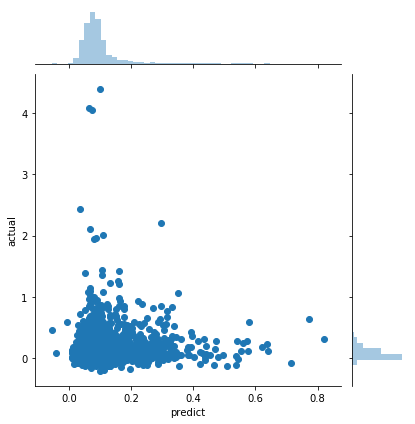

0.16805448797113137

In [31]:
result = exp.get_result(pred_model_re, val, label='label_high_20', is_plot=True)

spearmanr(result[label]["actual"], result[label]["predict"])[0]

In [32]:
df_del = df_bench[df_bench.diff_abs>0.5].reset_index()[['datetime', 'code']]
df_del['status']=1

df_learning_except_outline = pd.merge(df_learning.reset_index(), df_del, on=['datetime', 'code'], how='left')
df_learning_except_outline = df_learning_except_outline[df_learning_except_outline['status'].isnull()].set_index('datetime')
df_learning_except_outline.loc[:TRAIN_END]          

,code,base_date,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement AccountingStandard,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement ModifyDate,Forecast_FinancialStatement CompanyType,Forecast_FinancialStatement ChangeOfFiscalYearEnd,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalPeriodEnd,Result_Dividend ReportType,Result_Dividend FiscalYear,Result_Dividend ModifyDate,Result_Dividend RecordDate,Result_Dividend DividendPayableDate,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalPeriodEnd,Forecast_Dividend ReportType,Forecast_Dividend FiscalYear,Forecast_Dividend ModifyDate,Forecast_Dividend RecordDate,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,rsi,atr,macd,signal,dollar_vol,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,return_1d_lag1,return_5d_lag1,return_10d_lag1,...,return_21d_lag3,return_1d_lag4,return_5d_lag4,return_10d_lag4,return_21d_lag4,return_1d_lag5,return_5d_lag5,return_10d_lag5,return_21d_lag5,return_1month,return_2month,return_3month,volatility_2days,volatility_5days,volatility_10days,volatility_20days,volatility_40days,volatility_60days,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP,prediction_target,Effective Date,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare,market_cap,per,pbr,roe,profit_margin,equity_ratio,status
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,2753,2016/01/04,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,2391.0,2466.0,1645.0,21251.0,16962.0,NaN,NaN,NaN,ConsolidatedJP,2016/03,Annual,2016.0,2016/01/04,GB,False,30500.0,3110.0,3200.0,2130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,45.0,90.0,4710.0,12200.0,NaN,NaN,NaN,NaN,57462000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-12,0.01062,-0.04034,2016-01-19,0.01062,-0.05945,2016-02-02,0.03609,-0.10616,2016/01/04,4750.0,4800.0,4620.0,4710.0,1.0,4680.0,2015/12/30,4680.0,2015/12/30,30.0,0.641,4706.598,True,20210226,"AMIYAKI TEI CO.,LTD.",First Section (Domestic),6100.0,Retail Trade,14.0,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,3.225785e+10,19.609634,1.901771,0.096981,0.073589,0.798174,NaN
20

In [33]:
init_date_list =  [datetime.date(2020, 10, 1), datetime.date(2021, 1, 1)]
end_date_list = [datetime.date(2020, 12, 31), datetime.date(2021, 3, 27)]


rolling : False
学習期間 : 　2016-01-01 ~ 2020-10-01
検証期間 : 2020-10-01 ~ 2020-12-31


,predict,actual
predict,1.000000,0.122488
actual,0.122488,1.000000


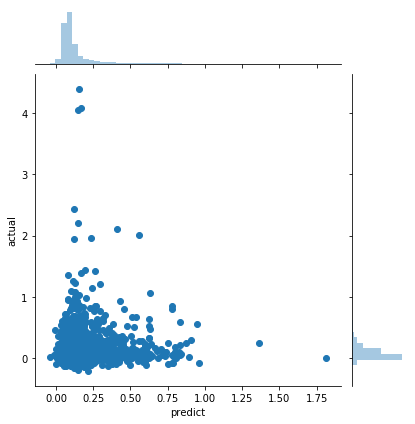

spearman_corr : 0.13145886334293033
-----------------------------------------
学習期間 : 　2016-01-01 ~ 2021-01-01
検証期間 : 2021-01-01 ~ 2021-03-27


,predict,actual
predict,1.000000,0.155084
actual,0.155084,1.000000


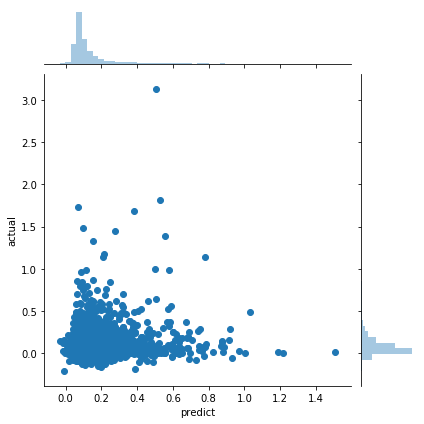

spearman_corr : 0.12855767714925154
-----------------------------------------


In [34]:
spearman_corr_list = exp.evaluate_time_split_corr(init_date_list, end_date_list, rolling=False)

rolling : False
学習期間 : 　2016-01-01 ~ 2020-10-01
検証期間 : 2020-10-01 ~ 2020-12-31


,predict,actual
predict,1.000000,0.116625
actual,0.116625,1.000000


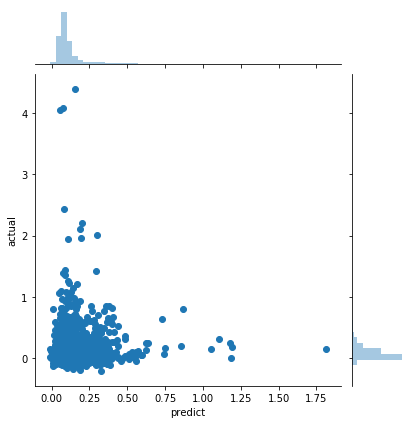

spearman_corr : 0.16350948065359572
-----------------------------------------
学習期間 : 　2016-01-01 ~ 2021-01-01
検証期間 : 2021-01-01 ~ 2021-03-27


,predict,actual
predict,1.000000,0.157514
actual,0.157514,1.000000


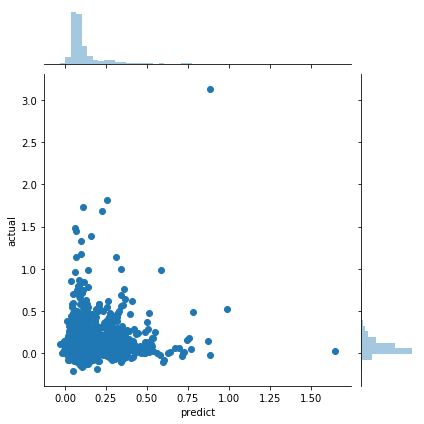

spearman_corr : 0.07330738246094505
-----------------------------------------


In [35]:
import importlib

importlib.reload( learner.preprocessors)
import learner.preprocessors
from learner.preprocessors import ExperimentManagement



exp_re = ExperimentManagement(df_learning=df_learning_except_outline, feature_columns=feature_columns)
exp_re.set_model_label(model=models[model], label=label)
spearman_corr_list_re = exp_re.evaluate_time_split_corr(init_date_list, end_date_list,  rolling=False)

In [36]:
f'{np.array(spearman_corr_list).mean()} +/- {np.array(spearman_corr_list).std() }'



'0.13000827024609093 +/- 0.0014505930968393976'

In [37]:
f'{np.array(spearman_corr_list_re).mean()} +/- {np.array(spearman_corr_list_re).std() }'

'0.11840843155727038 +/- 0.045101049096325334'

#  直近までデータを使用すべきか

rolling : True
学習期間 : 　2016-01-01 ~ 2020-10-01
検証期間 : 2020-10-01 ~ 2020-12-31


,predict,actual
predict,1.000000,0.122488
actual,0.122488,1.000000


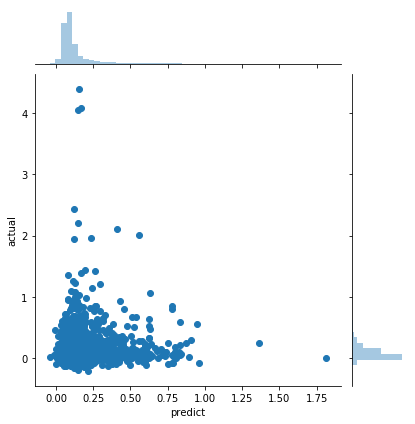

spearman_corr : 0.13145886334293033
-----------------------------------------
学習期間 : 　2016-01-01 ~ 2021-01-01
検証期間 : 2021-01-01 ~ 2021-03-27


,predict,actual
predict,1.000000,0.185236
actual,0.185236,1.000000


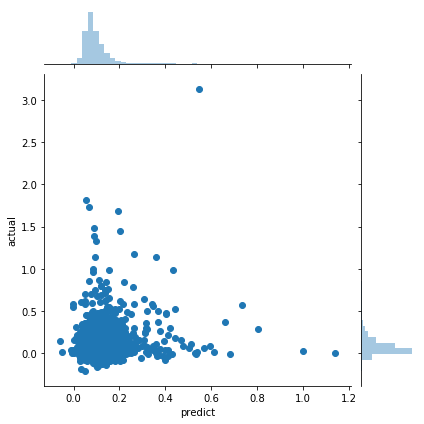

spearman_corr : 0.1194146085204112
-----------------------------------------
rolling : True
学習期間 : 　2016-01-01 ~ 2020-10-01
検証期間 : 2020-10-01 ~ 2020-12-31


,predict,actual
predict,1.000000,0.116625
actual,0.116625,1.000000


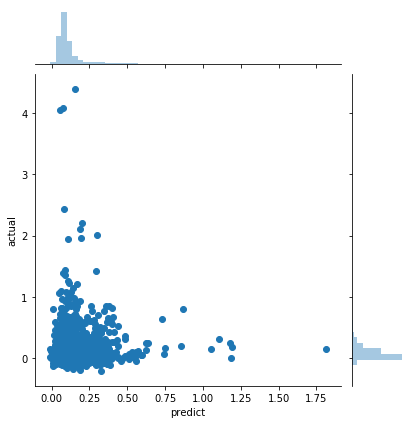

spearman_corr : 0.16350948065359572
-----------------------------------------
学習期間 : 　2016-01-01 ~ 2021-01-01
検証期間 : 2021-01-01 ~ 2021-03-27


,predict,actual
predict,1.000000,0.111244
actual,0.111244,1.000000


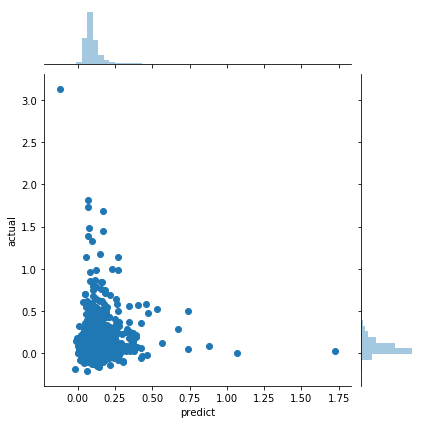

spearman_corr : 0.13524362374637286
-----------------------------------------


In [38]:
spearman_corr_list_rolling = exp.evaluate_time_split_corr(init_date_list, end_date_list, rolling=True)

spearman_corr_list_rolling_re = exp_re.evaluate_time_split_corr(init_date_list, end_date_list, rolling=True)



In [39]:
f'{np.array(spearman_corr_list_rolling).mean()} +/- {np.array(spearman_corr_list_rolling).std() }'



'0.12543673593167076 +/- 0.006022127411259563'

In [40]:


f'{np.array(spearman_corr_list_rolling_re).mean()} +/- {np.array(spearman_corr_list_rolling_re).std() }'

'0.1493765521999843 +/- 0.014132928453611429'

In [ ]:
# 効果なし？？